In [1]:
import os
from glob import glob
from pprint import pprint # pretty printing

# load the dreaded matplotlib
%matplotlib inline
import matplotlib.pyplot as plt

import pandas as pd      # data structures
import numpy as np       # basic numerical operations
import altair as alt     # plotting library
from scipy.io import wavfile # loading sound files
from ipywidgets import interact, fixed # buttons and stuff
# with respect to https://github.com/Chekos/blog-posts/tree/master/altair%20%2B%20ipywidgets


# tell plotting library not to try and hold everything in memory
alt.data_transformers.enable('json')
# and let it render good
alt.renderers.enable('notebook')

RendererRegistry.enable('notebook')

Before we start, we need to make sure you have the right packages! run

`pip install matplotlib pandas numpy altair scipy ipywidgets vega_datasets notebook vega`


## 1. *Geddat that data*
we reduced our spiketime data into 'long' format data - where every row is an observation (in this case spikes) and every column a variable.

We also combined all cells into a single file with clean_out_dir.m. First lets find our file

In [35]:
# start with tuning curves
tc_dir = os.path.join(os.getcwd(),'data','sili_probes','TC')
# make a string with a wildcard to search for the file
tc_search = tc_dir + os.sep + "*combined*.csv"
tc_fns = glob(tc_search)

#what did we get?
print("""\nDirectory: {}
          \nSearch string: {}
          \nGlobbed Filenames: {}""".format(tc_dir, tc_search, tc_fns))



Directory: /Users/jonny/GitHub/bootcamp_2018/data/sili_probes/TC
          
Search string: /Users/jonny/GitHub/bootcamp_2018/data/sili_probes/TC/*combined*.csv
          
Globbed Filenames: ['/Users/jonny/GitHub/bootcamp_2018/data/sili_probes/TC/out_combined_tones.csv']


Now load it!

In [36]:
if len(tc_fns) == 1:
    # make a pandas dataframe out of our .csv file
    df = pd.read_csv(tc_fns[0])
    
# print the first n rows (default 5, try giving another number as an argument)
#df.head()
df.head(10)

,amps,cell,dur,expt,freqs,rep,spikes
0,40,1,25,tuning_curve,1414.21,1,-15.800000
1,40,1,25,tuning_curve,1414.21,1,41.966667
2,40,1,25,tuning_curve,4000.00,1,-79.900000
3,40,1,25,tuning_curve,8000.00,1,9.700000
4,40,1,25,tuning_curve,11313.70,1,-80.300000
5,40,1,25,tuning_curve,22627.40,1,-8.900000
6,40,1,25,tuning_curve,22627.40,1,3.266667
7,40,1,25,tuning_curve,22627.40,1,25.333333
8,40,1,25,tuning_curve,22627.40,1,41.100000
9,40,1,25,tuning_curve,22627.40,1,79.166667


How many cells do we have?

In [37]:
# here we are using python string formatting, in general the format is
# add_string = "second sentence."
# "first sentence. {}".format(add_string) = "first sentence. second sentence."
# 

print("There are {} unique cells: {}".format(
        len(df['cell'].unique()), 
        df['cell'].unique()
    ))



There are 12 unique cells: [ 1 11 19 29 31 42 52 58 61 63 65 69]


The data is structured such that each row is a spike, and each column describes the spike.

Look at the rest of the column names - we have 

* **expt**: what type of experiment this data is from
* **freqs**: the frequency of the pure tone
* **amps**: the amplitude of the tone
* **rep**: the repetition of each amplitude/frequency combination
* **spikes**: the time of the spike (in ms from stimulus onset)

Lets check what `unique` frequencies and amplitudes we have

In [38]:
uq_freqs = df['freqs'].unique()
uq_amps  = df['amps'].unique()

print('Frequencies:\n')
pprint(uq_freqs)
print('\n\nAmplitudes:\n')
pprint(uq_amps)

Frequencies:

array([ 1.41421e+03,  4.00000e+03,  8.00000e+03,  1.13137e+04,
        2.26274e+04,  4.52548e+04,  6.40000e+04,  2.82843e+03,
        5.65685e+03,  1.60000e+04, -1.00000e+00,  2.00000e+03,
        3.20000e+04,  1.00000e+03])


Amplitudes:

array([40, 55, 70])


## 2. Spike Raster

We make a classic raster first.

I am trying out a new plotting library, [Altair](https://altair-viz.github.io), so refer to its documentation :)

In [39]:
def spike_raster(cell, data):
    # we first declare a Chart object, subsetting our data to a single cell
    # we then mark_circles with the encoding (map from data to graphics)
        
    chart = alt.Chart(data[data['cell'] == cell]).mark_circle().encode(
        x = alt.X('spikes'),      # X axis will be spike time
        y = alt.Y('rep' ),        # Y is the stimulus repetition
        size = alt.value(5),      # make the dots small
        opacity=alt.value(1.),    # opaque
        color=alt.condition(      # and...
            # if the spike happened during the stimulus presentation
            (alt.datum.spikes >= 0) & (alt.datum.spikes<=alt.datum.dur), 
            alt.value('red'),     # colored red
            alt.value('black')    # otherwise black
        )
    ).properties(
        width = 200,
        height = 30,
    ).facet(
        row='freqs',  # split the plot into rows by frequency
        column='amps' # and columns by amplitude
    )
    
    return chart

To be able to plot separate rasters for each cell, we wrap the function that generates our plot in one, `interact`, that makes a selection box that regenerates the plot when the selection is changed

In [40]:
interact(spike_raster,cell = sorted(df['cell'].unique()), data=fixed(df));

aW50ZXJhY3RpdmUoY2hpbGRyZW49KERyb3Bkb3duKGRlc2NyaXB0aW9uPXUnY2VsbCcsIG9wdGlvbnM9KDEsIDExLCAxOSwgMjksIDMxLCA0MiwgNTIsIDU4LCA2MSwgNjMsIDY1LCA2OSksIHbigKY=


## 3. Tuning Curves

What if we want to summarize? The receptive fields of auditory neurons are parameterized by the frequencies and amplitudes that drive spiking activity. We can map that by aggregating the spike trains across repetitions of the same sound.

Our summary will consist of...

1. Splitting our data into baseline spikes (before stimulus presentation) and spikes evoked by the stimulus
2. Counting the number of spikes that happen in each repetition of each stimulus
3. We want to measure the **change** in spiking activity due to the sound, so we subtract the baseline activity from the stimulus evoked activity
4. We then take the mean and standard deviation of baseline-subtracted spiking activity for each stimulus.
5. Plot it!

In [53]:
window = 75

# select just spikes within stim, aggregate
df_stim = df.loc[(df['spikes']>0) & (df['spikes']<window)]
# subset columns
df_stim = df_stim[['spikes','freqs','amps','cell','rep']]
# groupby cell, rep, and stim params, then count the number of spikes
df_stim = df_stim.groupby(['cell','freqs','amps','rep']).count()
# pandas is squirrelly, this just converts the data back into columns-only
df_stim = pd.DataFrame(df_stim.to_records())

# same for baseline
df_base = df.loc[(df['spikes']<0) & (df['spikes']>=window*-1.)]
df_base = df_base[['spikes','freqs','amps','cell','rep']]
df_base = df_base.groupby(['cell','freqs','amps','rep']).count()
df_base = pd.DataFrame(df_base.to_records())

## join
# join first to fill missing (0 spikes) values
# note that repetitions that have zero spikes at baseline or 
# during stim presentation will not be present in our summary,
# so sparsely firing cells will have spiking activity a bit high.
# that's fine for right now though...
df_tc = pd.merge(df_stim, df_base,
                 on=['cell','freqs', 'amps', 'rep'], how='outer')
# rename columns
df_tc.rename(index=str, 
             columns={'spikes_x':'spikes',
                      'spikes_y':'baseline'},
             inplace=True)

# fill nans
df_tc.fillna(0,inplace=True)

df_tc.head()




,cell,freqs,amps,rep,spikes,baseline
0,1,-1.0,40,14,1.0,0.0
1,1,-1.0,40,21,1.0,0.0
2,1,-1.0,55,5,1.0,0.0
3,1,-1.0,55,10,1.0,1.0
4,1,-1.0,55,11,2.0,0.0


In [54]:
# subtract
df_tc['spikes'] = df_tc['spikes']-df_tc['baseline']
# remove the other column
df_tc.drop('baseline', axis=1,inplace=True)

# divide by the duration to get mean spikes/s 
# (assuming durations uniform)
df_tc['spikes'] = df_tc['spikes']/(df['dur'][0]/1000.)

In [55]:
# aggregate over repetitions
df_tc_summary = df_tc.groupby(['cell','freqs','amps']).mean()
df_tc_std     = df_tc.groupby(['cell','freqs','amps']).std()

# the mean and std of the repetition number don't rly mean much here so we drop it
df_tc_summary.drop('rep',axis=1,inplace=True)
df_tc_std.drop('rep',axis=1,inplace=True)

df_tc_summary = pd.merge(df_tc_summary.reset_index(), df_tc_std.reset_index(),
                 on=['freqs', 'amps', 'cell'], how='outer')

# rename columns
df_tc_summary.rename(index=str, 
             columns={'spikes_x':'spikes',
                      'spikes_y':'std'},
             inplace=True)

df_tc_summary.head()




,cell,freqs,amps,spikes,std
0,1,-1.0,40,0.000000,46.188022
1,1,-1.0,55,20.000000,51.639778
2,1,-1.0,70,75.789474,39.765394
3,1,1000.0,40,5.714286,48.599432
4,1,1000.0,55,0.000000,56.568542


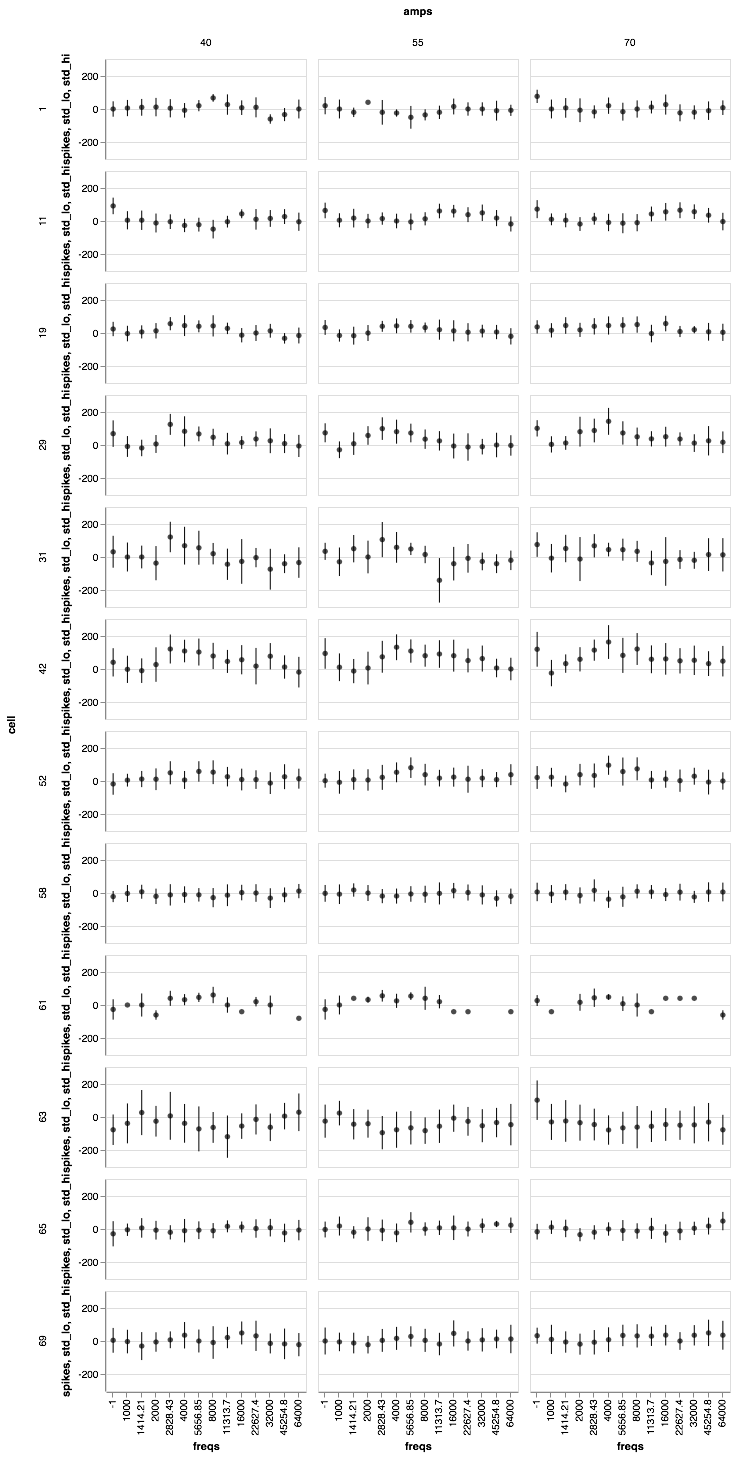

In [56]:
df_tc_summary['std_lo'] = df_tc_summary['spikes']-df_tc_summary['std']
df_tc_summary['std_hi'] = df_tc_summary['spikes']+df_tc_summary['std']

points = alt.Chart().mark_circle(
            ).encode(
                x=alt.X('freqs:O'),
                y=alt.Y('spikes:Q'),
                color=alt.value('black')
            ).properties(
                width = 200,
                height = 100
            )

bars = alt.Chart().mark_rule().encode(
y=alt.Y('std_lo:Q'),
y2=alt.Y('std_hi:Q'),
x=alt.X('freqs:O'))

chart = points+bars

chart.facet(row='cell:N',column='amps:O',data=df_tc_summary)


Or if we want to forget about uncertainty as a heatmap

In [57]:
def tc_heatmap(data, cell):
    points = alt.Chart(data[data['cell']==cell]).mark_rect(
                ).encode(
                    x=alt.X('freqs:O'),
                    y=alt.Y('amps:O'),
                    color='spikes:Q'
                ).properties(
                    width = 600,
                    height = 200
                )
    return points

In [58]:
interact(tc_heatmap,cell = sorted(df_tc_summary['cell'].unique()), data=fixed(df_tc_summary));

aW50ZXJhY3RpdmUoY2hpbGRyZW49KERyb3Bkb3duKGRlc2NyaXB0aW9uPXUnY2VsbCcsIG9wdGlvbnM9KDEsIDExLCAxOSwgMjksIDMxLCA0MiwgNTIsIDU4LCA2MSwgNjMsIDY1LCA2OSksIHbigKY=


## 4. PINPed cells

Some cells in these animals have channelrhodopsin in them, and when exposed to blue light they spike. In order to see if we have those cells we measure the how reliably spikes are evoked by the light pulses

In [66]:
# find the file! this time let's wrap it in a function

def load_spikes(expt_type):

    # start with tuning curves
    tc_dir = os.path.join(os.getcwd(),'data','sili_probes',expt_type)
    # make a string with a wildcard to search for the file
    tc_search = tc_dir + os.sep + "*combined*.csv"
    tc_fns = glob(tc_search)

    #what did we get?
    print("""\nDirectory: {}
              \nSearch string: {}
              \nGlobbed Filenames: {}""".format(tc_dir, tc_search, tc_fns))
    
    if len(tc_fns) == 1:
        # make a pandas dataframe out of our .csv file
        df = pd.read_csv(tc_fns[0])
        return df
    else:
        print("Multiple or zero combined .csvs found, try again!")
        return None
    
pinp = load_spikes('PINP')
    
# print the first n rows (default 5, try giving another number as an argument)
pinp.head()


Directory: /Users/jonny/GitHub/bootcamp_2018/data/sili_probes/PINP
              
Search string: /Users/jonny/GitHub/bootcamp_2018/data/sili_probes/PINP/*combined*.csv
              
Globbed Filenames: ['/Users/jonny/GitHub/bootcamp_2018/data/sili_probes/PINP/out_combined_pinp.csv']


,cell,expt,isi,n_pulses,pulse_width,rep,spikes,type
0,1,pinp,NaN,NaN,20,1,-249.300000,pulse
1,1,pinp,NaN,NaN,20,1,-232.233333,pulse
2,1,pinp,NaN,NaN,20,1,-153.433333,pulse
3,1,pinp,NaN,NaN,20,2,157.300000,pulse
4,1,pinp,NaN,NaN,20,2,409.966667,pulse


Notice we have some NaNs right off the bat - notice our new column, 'type'

In [67]:
pinp['type'].unique()

array(['pulse', 'train'], dtype=object)

We have two types of stimuli, and the isi and n_pulses only apply to the 'train' type. Let's start with the single pulse though.

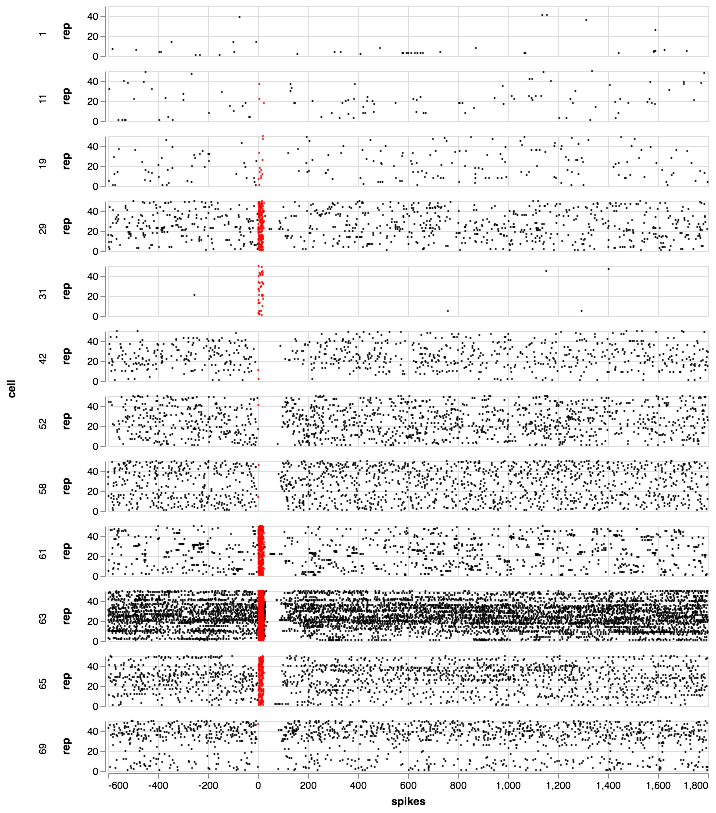

In [69]:
laser_slop = 5

chart = alt.Chart(pinp[pinp['type']=='pulse']).mark_circle().encode(
    x = alt.X('spikes'),      # X axis will be spike time
    y = alt.Y('rep' ),        # Y is the stimulus repetition
    size = alt.value(5),      # make the dots small
    opacity=alt.value(1.),    # opaque
    color=alt.condition(      # and...
        # if the spike happened during the stimulus presentation
        (alt.datum.spikes >= 0) & (alt.datum.spikes<=alt.datum.pulse_width+laser_slop), 
        alt.value('red'),     # colored red
        alt.value('black')    # otherwise black
    )
).properties(
    width = 600,
    height = 50,
).facet(
    row='cell',  # split the plot into rows by cell
)

chart

There should be some cells activated by the laser, some inhibited, and some unaffected. let's be a bit more quantitative.

In [ ]:
# subset data
pinp_pulse = pinp[pinp['type']=='pulse']

# lets try it a slightly different way, with iteration
# first lets see what we're looking at
for i, group in pinp_pulse.groupby(['cell','rep']):
    print(i)
    print(group)

In [ ]:
# now let's iterate and summarize
# we make some temporary lists to store our values
cell_l     = []
pulse_l    = []
rep_l      = []
evoked_l   = []
baseline_l = []
spikes_l   = []

# the protein has a bit of latency
laser_slop = 5. #ms
# how long before stim should we look for baseline?
pre_stim = 400. #ms

for i, group in pinp_pulse.groupby(['cell','rep']):
    # store uncalculated values
    cell_l.append(group['cell'].iloc[0])
    pulse_l.append(group['pulse_width'].iloc[0])
    rep_l.append(group['rep'].iloc[0])
    
    # calculate laser evoked spikes
    evoked = group[(group['spikes']>laser_slop) & (group['spikes']<group['pulse_width']+laser_slop)].count()['spikes']
    # normalize to spikes/s
    evoked = evoked/((group['pulse_width'].iloc[0]+laser_slop)/1000.)
    evoked_l.append(evoked)
    
    # and baseline
    baseline = group[(group['spikes']<0)&(group['spikes']>(pre_stim*-1))].count()['spikes']
    baseline = baseline/(pre_stim/1000.)
    baseline_l.append(baseline)
    
    # and the difference
    spikes_l.append(evoked-baseline)
    
#now wrap them up into a new df
pulse_summary_rep = pd.DataFrame({'cell':cell_l,
                              'pulse_width':pulse_l,
                              'rep':rep_l,
                              'evoked':evoked_l,
                              'baseline':baseline_l,
                              'spikes':spikes_l})

pulse_summary_rep.head()    

In [ ]:
# now aggregate over repetitions
pulse_summary = pulse_summary_rep.groupby('cell').agg({'spikes':['mean','std']})
pulse_summary = pd.DataFrame(pulse_summary.to_records())
col_names = pulse_summary.columns
pulse_summary.rename(index=str, 
             columns={col_names[1]:'mean',
                      col_names[2]:'std'},
             inplace=True)
pulse_summary

In [ ]:
# plot it
def pinp_summary(pulse_summary_rep):
    pulse_summary = pulse_summary_rep.groupby('cell').agg({'spikes':['mean','std']})
    pulse_summary = pd.DataFrame(pulse_summary.to_records())
    col_names = pulse_summary.columns
    pulse_summary.rename(index=str, 
             columns={col_names[1]:'mean',
                      col_names[2]:'std'},
             inplace=True)
    pulse_summary['stdhi'] = pulse_summary['mean']+pulse_summary['std']
    pulse_summary['stdlo'] = pulse_summary['mean']-pulse_summary['std']

    chart = alt.Chart(pulse_summary_rep).mark_circle().encode(
        x = alt.X('cell:O'),      # X axis will be spike time
        y = alt.Y('spikes:Q' ),        # Y is the stimulus repetition
        size = alt.value(5),      # make the dots small
        opacity=alt.value(0.8),    # opaque
        color=alt.value('red')
    ).properties(
        width = 600,
        height = 200,
    )

    mean_point = alt.Chart(pulse_summary).mark_circle().encode(
        x = alt.X('cell:O'),
        y = alt.Y('mean:Q'),
        size=alt.value(40),
        color=alt.value('black')
    )


    bars = alt.Chart(pulse_summary).mark_rule().encode(
        y=alt.Y('stdlo:Q'),
        y2=alt.Y('stdhi:Q'),
        x=alt.X('cell:O'))

    return chart + mean_point + bars

chart = pinp_summary(pulse_summary_rep)
chart

How about the spike trains? We have information about the trains themselves - the interpulse-interval (amount of time between pulses), the pulse width, and the number of pulses. From that we can reconstruct when the laser was on and off with modular arithmetic

In [ ]:
pinp_train = pinp[pinp['type']=='train']

# get stim information, assuming it's all the same across presentations
isi = pinp_train['isi'].iloc[0]
n_pulses = pinp_train['n_pulses'].iloc[0]
pulse_dur = pinp_train['pulse_width'].iloc[0]

print('ISI: {}ms, pulse duration: {}ms, n pulses: {}'.format(isi, pulse_dur, n_pulses))

In [ ]:
chart = alt.Chart(pinp_train).mark_circle().encode(
    x = alt.X('spikes'),      # X axis will be spike time
    y = alt.Y('rep' ),        # Y is the stimulus repetition
    size = alt.value(5),      # make the dots small
    opacity=alt.value(1.),    # opaque
    color=alt.condition(      # and...
        # if the spike happened during the stimulus presentation
        (alt.datum.spikes >= 0) & # spike after laser pulses start
        (alt.datum.spikes % alt.datum.isi < alt.datum.pulse_width+laser_slop) & # before the end of each pulse
        (alt.datum.spikes % alt.datum.isi > laser_slop) &                       # after the time it takes for the laser to take effect
        (alt.datum.spikes < alt.datum.isi * alt.datum.n_pulses),                # before the laser pulses stop
        alt.value('red'),     # colored red
        alt.value('black')    # otherwise black
    )
).properties(
    width = 600,
    height = 50,
).facet(
    row='cell',  # split the plot into rows by cell
)

chart

Now do the same analysis as before...

In [ ]:
# now let's iterate and summarize
# we make some temporary lists to store our values
cell_l     = []
pulse_l    = []
rep_l      = []
evoked_l   = []
baseline_l = []
spikes_l   = []

# the protein has a bit of latency
laser_slop = 5. #ms
# how long before stim should we look for baseline?
pre_stim = 400. #ms

for i, group in pinp_train.groupby(['cell','rep']):
    # store uncalculated values
    cell_l.append(group['cell'].iloc[0])
    pulse_l.append(group['pulse_width'].iloc[0])
    rep_l.append(group['rep'].iloc[0])
    
    # calculate laser evoked spikes
    evoked = group[(group['spikes']>0)&
                   (group['spikes']%group['isi']>laser_slop) & 
                   (group['spikes']%group['isi']<group['pulse_width']+laser_slop)&
                   (group['spikes']<group['isi']*group['n_pulses'])].count()['spikes']
    # normalize to spikes/s
    evoked = evoked/((group['pulse_width'].iloc[0]*group['n_pulses'].iloc[0])/1000.)
    evoked_l.append(evoked)
    
    # and baseline
    baseline = group[(group['spikes']<0)&(group['spikes']>(pre_stim*-1))].count()['spikes']
    baseline = baseline/(pre_stim/1000.)
    baseline_l.append(baseline)
    
    # and the difference
    spikes_l.append(evoked-baseline)
    
#now wrap them up into a new df
train_summary_rep = pd.DataFrame({'cell':cell_l,
                              'pulse_width':pulse_l,
                              'rep':rep_l,
                              'evoked':evoked_l,
                              'baseline':baseline_l,
                              'spikes':spikes_l})


In [ ]:
# plot it
chart = pinp_summary(train_summary_rep)
chart

Note that both of these analysis are measuring the same thing, so we can join them together :)

In [ ]:
pinp_reps = pd.concat([pulse_summary_rep, train_summary_rep])

pinp_summary(pinp_reps)

## 5. Speech Sounds

What about the speech sounds? first let's load the sounds.

In [ ]:
# get the directory
sound_dir = os.path.join(os.getcwd(),'sounds','pshift16')
# make a string with a wildcard to search for the file
sound_search = sound_dir + os.sep + "*.wav"
sound_fns = glob(sound_search)
sound_fns

In [ ]:
sounds = {}
for fn in sound_fns:
    fs, wave = wavfile.read(fn)
    name = fn.split('/')[-1].split('.')[0]
    sounds[name] = wave
    

In [ ]:
fig, ax = plt.subplots(2,1, sharex=True)
ax[0].hist(pinp_pulse['spikes']/1000., bins=30,zorder=1)
ax[0].scatter(pinp_pulse['spikes']/1000.,pinp_pulse['rep'],s=0.5,c='red',alpha=1.0,zorder=2)
ax[1].specgram(sounds['youregreat_pshift'],Fs=192000)
plt.show()